## Analysis part 2

In [1]:
from config import CONFIG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import series_to_supervised
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_json("eth-donation-requests.json")

In [3]:
df['tagged_begging'] = pd.to_datetime(df['tagged_begging'])

In [4]:
df = df.set_index(pd.DatetimeIndex(df['tagged_begging']))

In [5]:
df = df.groupby(pd.Grouper(key='tagged_begging', freq='15Min', base=0, label='right'))

In [6]:
df = df.describe()

In [7]:
df_count = df.unstack()['tagged_begging']['count']

In [8]:
values = df_count.values
#df_count.head()
type(values)

numpy.ndarray

In [9]:
values.shape

(9788,)

In [10]:
#ax = df_count.plot()
#plt.show()

In [11]:
# parameters to prepare the dataset for learning # param 
n_lag = 96
n_out = 4
n_features = 1
n_lag,n_features,n_out

(96, 1, 4)

In [12]:
values.shape

(9788,)

In [13]:
values = values.reshape(values.shape[0], 1)
#values = values.reshape(-1, 1)

In [14]:
values.shape

(9788, 1)

In [15]:
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# frame as supervised learning
#reframed = series_to_supervised(scaled, n_lag, n_out)
reframed = series_to_supervised(values, n_lag, n_out)
reframed.head()

,var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),var1(t-90),var1(t-89),var1(t-88),var1(t-87),...,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
96,2,6,9,7,1,4,0,4,9,8,...,3,4,8,5,5,6,7,9,13,13
97,6,9,7,1,4,0,4,9,8,1,...,4,8,5,5,6,7,9,13,13,6
98,9,7,1,4,0,4,9,8,1,3,...,8,5,5,6,7,9,13,13,6,10
99,7,1,4,0,4,9,8,1,3,16,...,5,5,6,7,9,13,13,6,10,11
100,1,4,0,4,9,8,1,3,16,13,...,5,6,7,9,13,13,6,10,11,14


In [17]:
reframed_values = reframed.values
# split into train and test sets
training_size = int(0.8* reframed_values.shape[0])
train = reframed_values[:training_size, :]
test = reframed_values[training_size:, :]

In [18]:
# split into input and outputs
n_obs = n_lag * n_features

# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

n_outputs = n_out * n_features
train_x, train_y = train[:, :n_obs], train[:, -n_out:]
test_x, test_y = test[:, :n_obs], test[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_lag, n_features))
test_x = test_x.reshape((test_x.shape[0], n_lag, n_features))

# reshape output to be 3D [samples, timesteps, features]
train_y = train_y.reshape(-1, n_out, 1)
test_y = test_y.reshape(-1, n_out, 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((7751, 96, 1), (7751, 4, 1), (1938, 96, 1), (1938, 4, 1))


In [19]:
model_name="model.json"
model_weights_name="weights.h5"

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM, CuDNNLSTM, GRU,CuDNNGRU
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint

units= CONFIG['lstm_hidden_size']
dropout = .1

# design network
model = Sequential()
model.add(Bidirectional(LSTM(units), input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(dropout))

model.add(RepeatVector(n_out))

model.add(LSTM(units/2, return_sequences=True))
model.add(Dropout(dropout))

# We're only concerned with the estimating the close value,
# otherwise use n_outputs instead of 1
# Dense(n_outputs, ...
model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# store model
# serialize model to JSON
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)

model.summary()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 25)             12600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 25)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 1)              26        
Total params: 33,426
Trainable params: 33,426
Non-trainable params: 0
_________________________________________________________________


In [21]:
#epochs=100
epochs=150
batch_size=512

In [22]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose=1, shuffle=False,
                    callbacks=[ModelCheckpoint(model_weights_name, monitor='val_loss', verbose=1,save_best_only='true',
                                              save_weights_only=True)])

Train on 7751 samples, validate on 1938 samples
Epoch 1/150
7751/7751 [==============================] - 11s 1ms/step - loss: 120.4220 - acc: 0.0655 - val_loss: 152.1705 - val_acc: 0.0695

Epoch 00001: val_loss improved from inf to 152.17045, saving model to weights.h5
Epoch 2/150
7751/7751 [==============================] - 9s 1ms/step - loss: 88.5537 - acc: 0.0782 - val_loss: 118.8511 - val_acc: 0.0654

Epoch 00002: val_loss improved from 152.17045 to 118.85112, saving model to weights.h5
Epoch 3/150
7751/7751 [==============================] - 9s 1ms/step - loss: 71.1760 - acc: 0.0644 - val_loss: 105.0304 - val_acc: 0.0600

Epoch 00003: val_loss improved from 118.85112 to 105.03037, saving model to weights.h5
Epoch 4/150
7751/7751 [==============================] - 10s 1ms/step - loss: 64.8413 - acc: 0.0668 - val_loss: 97.9297 - val_acc: 0.0775

Epoch 00004: val_loss improved from 105.03037 to 97.92974, saving model to weights.h5
Epoch 5/150
7751/7751 [==============================

7751/7751 [==============================] - 12s 2ms/step - loss: 28.2414 - acc: 0.1296 - val_loss: 49.7353 - val_acc: 0.1280

Epoch 00037: val_loss improved from 50.54209 to 49.73527, saving model to weights.h5
Epoch 38/150
7751/7751 [==============================] - 10s 1ms/step - loss: 28.0457 - acc: 0.1291 - val_loss: 49.2643 - val_acc: 0.1282

Epoch 00038: val_loss improved from 49.73527 to 49.26427, saving model to weights.h5
Epoch 39/150
7751/7751 [==============================] - 9s 1ms/step - loss: 27.7845 - acc: 0.1275 - val_loss: 49.5559 - val_acc: 0.1249

Epoch 00039: val_loss did not improve from 49.26427
Epoch 40/150
7751/7751 [==============================] - 11s 1ms/step - loss: 27.4768 - acc: 0.1292 - val_loss: 48.3919 - val_acc: 0.1294

Epoch 00040: val_loss improved from 49.26427 to 48.39189, saving model to weights.h5
Epoch 41/150
7751/7751 [==============================] - 10s 1ms/step - loss: 26.9948 - acc: 0.1275 - val_loss: 48.6515 - val_acc: 0.1294

Epoch 0


Epoch 00075: val_loss did not improve from 39.36058
Epoch 76/150
7751/7751 [==============================] - 9s 1ms/step - loss: 21.7166 - acc: 0.1306 - val_loss: 39.9485 - val_acc: 0.1298

Epoch 00076: val_loss did not improve from 39.36058
Epoch 77/150
7751/7751 [==============================] - 9s 1ms/step - loss: 21.3481 - acc: 0.1323 - val_loss: 38.8092 - val_acc: 0.1227

Epoch 00077: val_loss improved from 39.36058 to 38.80918, saving model to weights.h5
Epoch 78/150
7751/7751 [==============================] - 9s 1ms/step - loss: 21.2565 - acc: 0.1349 - val_loss: 39.4627 - val_acc: 0.1157

Epoch 00078: val_loss did not improve from 38.80918
Epoch 79/150
7751/7751 [==============================] - 11s 1ms/step - loss: 21.0745 - acc: 0.1308 - val_loss: 39.9747 - val_acc: 0.1233

Epoch 00079: val_loss did not improve from 38.80918
Epoch 80/150
7751/7751 [==============================] - 9s 1ms/step - loss: 20.8895 - acc: 0.1363 - val_loss: 39.5808 - val_acc: 0.1201

Epoch 0008

7751/7751 [==============================] - 12s 1ms/step - loss: 20.4011 - acc: 0.1297 - val_loss: 34.9172 - val_acc: 0.1162

Epoch 00117: val_loss improved from 35.38943 to 34.91723, saving model to weights.h5
Epoch 118/150
7751/7751 [==============================] - 10s 1ms/step - loss: 19.4986 - acc: 0.1302 - val_loss: 34.8708 - val_acc: 0.1228

Epoch 00118: val_loss improved from 34.91723 to 34.87083, saving model to weights.h5
Epoch 119/150
7751/7751 [==============================] - 10s 1ms/step - loss: 18.9505 - acc: 0.1346 - val_loss: 35.3004 - val_acc: 0.1184

Epoch 00119: val_loss did not improve from 34.87083
Epoch 120/150
7751/7751 [==============================] - 10s 1ms/step - loss: 18.6958 - acc: 0.1350 - val_loss: 36.4796 - val_acc: 0.1201

Epoch 00120: val_loss did not improve from 34.87083
Epoch 121/150
7751/7751 [==============================] - 11s 1ms/step - loss: 18.4317 - acc: 0.1388 - val_loss: 35.7163 - val_acc: 0.1229

Epoch 00121: val_loss did not impro

In [23]:
# Load the best weights
model.load_weights(model_weights_name)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_x, test_y)
print(model.metrics_names)
print(score)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

1938/1938 [==============================] - 2s 1ms/step
['loss', 'acc']
[33.3654410979327, 0.1262899897108383]

acc: 12.63%


In [24]:
from matplotlib import pyplot

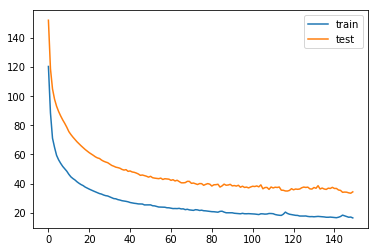

In [25]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# Test the prediction of test data
y = model.predict(test_x)

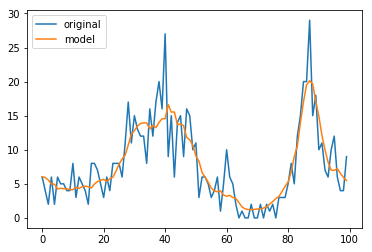

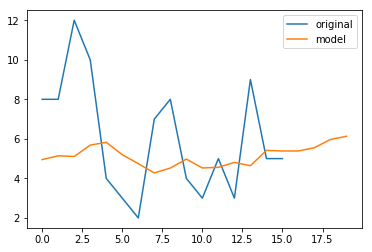

In [27]:
a = test_y[:,0]
b = y[:,0]
c = np.append(b, y[-1], axis=0)

# Show how the model fits the test data
pyplot.plot(a[:100], label='original')
pyplot.plot(b[:100], label='model')
pyplot.legend()
pyplot.show()

# Show how the model predicts data
pos = int(a.shape[0]-n_out*4)
pyplot.plot(a[pos:], label='original')
pyplot.plot(c[pos:], label='model')
pyplot.legend()
pyplot.show()
